# ***Data Understanding***

In [1]:
#Upload the file
from google.colab import files
uploaded = files.upload()

Saving Corona.csv to Corona.csv


In [2]:
#Load the dataset
import pandas as pd
df = pd.read_csv('Corona.csv', encoding='ISO-8859-1')

In [3]:
#Display first few rows of the dataset
print(df.head())

   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  


In [4]:
#Display last few rows of the dataset
print(df.tail())

       UserName  ScreenName                      Location     TweetAt  \
41152     44951       89903  Wellington City, New Zealand  14-04-2020   
41153     44952       89904                           NaN  14-04-2020   
41154     44953       89905                           NaN  14-04-2020   
41155     44954       89906                           NaN  14-04-2020   
41156     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet           Sentiment  
41152  Airline pilots offering to stock supermarket s...             Neutral  
41153  Response to complaint not provided citing COVI...  Extremely Negative  
41154  You know itÂs getting tough when @KameronWild...            Positive  
41155  Is it wrong that the smell of hand sanitizer i...             Neutral  
41156  @TartiiCat Well new/used Rift S are going for ...            Negative  


In [5]:
#Display basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB
None


In [6]:
#Display numbers of rows and columns
print(df.shape)

(41157, 6)


# ***Data Cleaning***

In [7]:
#Identify missing values
print(df.isnull().sum())

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [8]:
#Identify duplicate rows
print(df.duplicated().sum())

0


In [9]:
#Remove columns
df = df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1)

In [10]:
#Class imbalance
print(df['Sentiment'].value_counts())

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64


In [11]:
#Remove 'Neutral' in sentiment (wrongly labeled neutral)
df = df[df['Sentiment'] != 'Neutral']

# ***Model Preprocessing***

In [12]:
#Label simplification
def simplify_sentiment(label):
    if label in ['Positive', 'Extremely Positive']:
        return 'Positive'
    elif label in ['Negative', 'Extremely Negative']:
        return 'Negative'
    else:
        return 'Other'

df['simplified_sentiment'] = df['Sentiment'].apply(simplify_sentiment)

In [13]:
#Clean
import re
from bs4 import BeautifulSoup

def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^A-Za-z0-9\s.,!?']", "", text)
    text = text.strip()
    return text

df['clean_tweet'] = df['OriginalTweet'].apply(clean_text)

# ***Model Implementation and evaluation***

In [14]:
#model implemetation
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_tweet'])

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, df['simplified_sentiment'], test_size=0.2, random_state=42)

In [16]:
#Import the SMOTE
!pip install imblearn
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [17]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
le = LabelEncoder()
y_train_resampled_enc = le.fit_transform(y_train_resampled)
y_test_enc = le.transform(y_test)

In [18]:
#XGBoost classifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(X_train_resampled, y_train_resampled_enc)
y_pred_enc = xgb_model.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.809089550007475
              precision    recall  f1-score   support

    Negative       0.77      0.83      0.80      3005
    Positive       0.85      0.79      0.82      3684

    accuracy                           0.81      6689
   macro avg       0.81      0.81      0.81      6689
weighted avg       0.81      0.81      0.81      6689



# ***Hyperparameter tuning***

In [19]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_resampled, y_train_resampled_enc)

print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best Cross-Validated Accuracy: 0.8177830385740148


# ***Final model***

In [20]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

best_xgb_model = xgb.XGBClassifier(
    eval_metric='mlogloss',
    subsample=1.0,
    n_estimators=200,
    max_depth=12,
    learning_rate=0.2,
    colsample_bytree=1.0,
    random_state=42
)

best_xgb_model.fit(X_train_resampled, y_train_resampled_enc)

y_pred_enc = best_xgb_model.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)

print("Final Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Final Test Accuracy: 0.8422783674689789
              precision    recall  f1-score   support

    Negative       0.81      0.85      0.83      3005
    Positive       0.87      0.84      0.85      3684

    accuracy                           0.84      6689
   macro avg       0.84      0.84      0.84      6689
weighted avg       0.84      0.84      0.84      6689



# ***Predictive behaviour evaluation***

<Figure size 600x500 with 0 Axes>

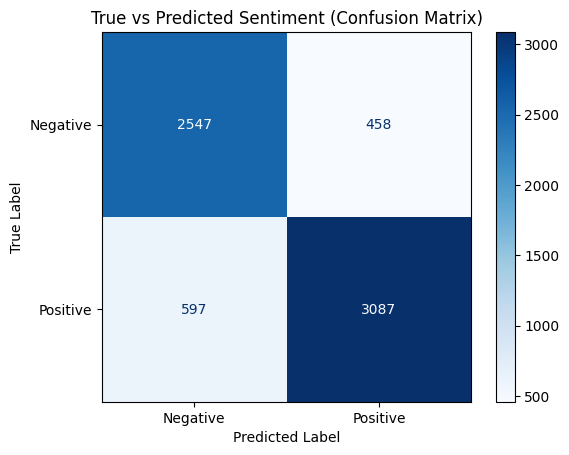

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=le.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("True vs Predicted Sentiment (Confusion Matrix)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()